# 앙상블 주식 채권 비중별

- 투자 자산 : 주식(코스피200, SPY), 채권(20년 만기 국고채, TLT)
- 투자비율 : 다음과 같은 11개의 포트폴리오(투자 전략)를 만든다(매월 말 해당 비중대로 리밸런싱).
- 매월 말 11개 전략의 수익곡선 확인
  - 주식 100%~0% 채권 0~100%
- 각 수익곡선의 최근 '6개월 모멘텀(수익률) / 최근 6개월 수익률 변동성' 상위 n 개 포트폴리오를 선정
- 동일비중으로 투자
- 결과
  - 한국 그림 2-39
      - 코스피 10.0%/-47..0%
      - 20년 만기 국고채 13.0%/-20.7%
      - 전략 15.7%/-14.5%
  - 미국 그림 2-40
      - SPY 9.7%/-50.8%
      - TLT 6.3%/-21.8%
      - 전략 10.7%/-17.5%

In [1]:
from settings import *

In [2]:
tickers = ['kodex200', 'kbond20y']
data = get_data()
data = data[tickers].copy()
data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 5433 entries, 2000-01-04 to 2021-12-30
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   kodex200  5433 non-null   float64
 1   kbond20y  5433 non-null   float64
dtypes: float64(2)
memory usage: 127.3 KB


In [3]:
data['2001-7'].tail()

,kodex200,kbond20y
Date,,
2001-07-25,4551.059,26258.091
2001-07-26,4570.826,26380.025
2001-07-27,4675.783,26350.612
2001-07-30,4608.011,26284.655
2001-07-31,4678.070,26180.015


In [4]:
s = '2001-1-31'
# e = '2017-6-30'
e = '2021-12-30'
start = '2001-7-31'

In [5]:
data = data[s:]

In [6]:
data

,kodex200,kbond20y
Date,,
2001-01-31,5399.557,26635.995
2001-02-01,5350.652,26644.371
2001-02-02,5311.437,26846.446
2001-02-05,5046.944,26856.093
2001-02-06,5112.289,27256.726
...,...,...
2021-12-24,40115.000,127340.000
2021-12-27,39880.000,127645.000
2021-12-28,40205.000,127645.000


In [7]:
def strategy(name, data, index, bond):
    s = bt.Strategy(name,
            [
                bt.algos.RunMonthly(run_on_end_of_period=True),
                bt.algos.SelectAll(),
                bt.algos.WeighSpecified(kodex200=index, kbond20y=bond),
                # PrintTempWeights(),
                bt.algos.Rebalance(),
            ])

    return bt.Backtest(s, data, initial_capital=100000000.0)

In [8]:
t1 = strategy("t1",   data, 1.0, 0.0)
t2 = strategy("t2",   data, 0.9, 0.1)
t3 = strategy("t3",   data, 0.8, 0.2)
t4 = strategy("t4",   data, 0.7, 0.3)
t5 = strategy("t5",   data, 0.6, 0.4)
t6 = strategy("t6",   data, 0.5, 0.5)
t7 = strategy("t7",   data, 0.4, 0.6)
t8 = strategy("t8",   data, 0.3, 0.7)
t9 = strategy("t9",   data, 0.2, 0.8)
t10 = strategy("t10", data, 0.1, 0.9)
t11 = strategy("t11", data, 0.0, 1.0)

In [9]:
r_all = bt.run(t1,t2,t3,t4,t5,t6,t7,t8,t9,t10,t11)

In [10]:
r_all.display()

Stat                 t1          t2          t3          t4          t5          t6          t7          t8          t9          t10         t11
-------------------  ----------  ----------  ----------  ----------  ----------  ----------  ----------  ----------  ----------  ----------  ----------
Start                2001-01-30  2001-01-30  2001-01-30  2001-01-30  2001-01-30  2001-01-30  2001-01-30  2001-01-30  2001-01-30  2001-01-30  2001-01-30
End                  2021-12-30  2021-12-30  2021-12-30  2021-12-30  2021-12-30  2021-12-30  2021-12-30  2021-12-30  2021-12-30  2021-12-30  2021-12-30
Risk-free rate       0.00%       0.00%       0.00%       0.00%       0.00%       0.00%       0.00%       0.00%       0.00%       0.00%       0.00%

Total Return         638.39%     650.67%     652.96%     645.22%     627.61%     600.98%     566.27%     524.83%     478.08%     427.67%     375.23%
Daily Sharpe         0.54        0.59        0.64        0.70        0.76        0.82        0.85     

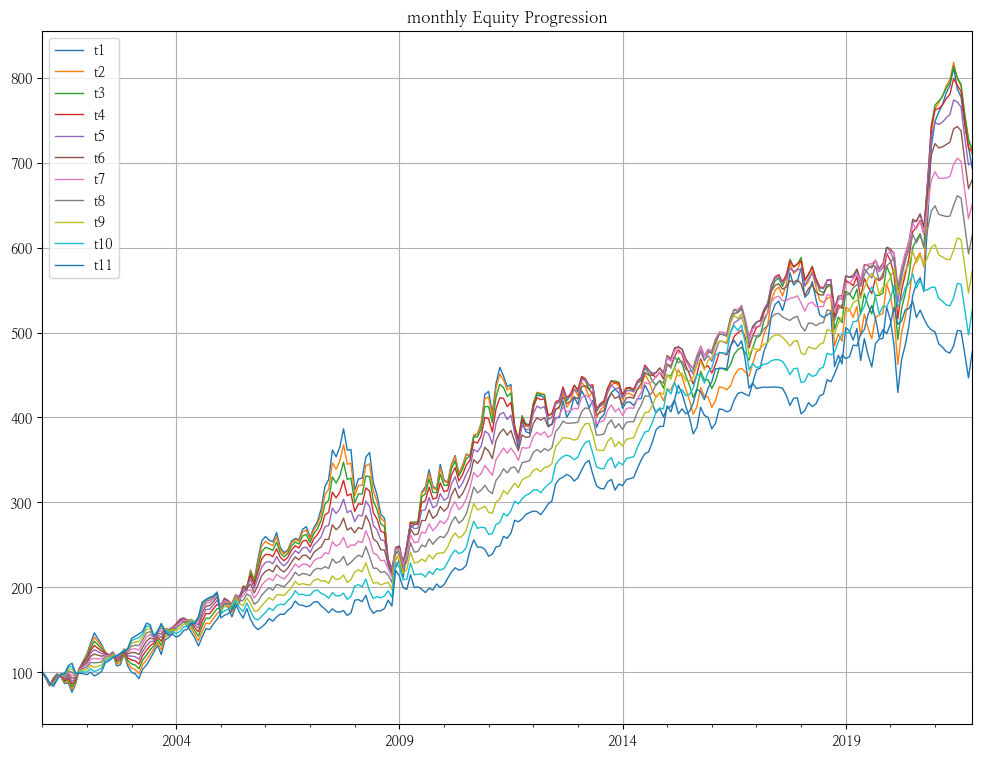

In [11]:
r_all.plot(freq='M', figsize=(12, 9));

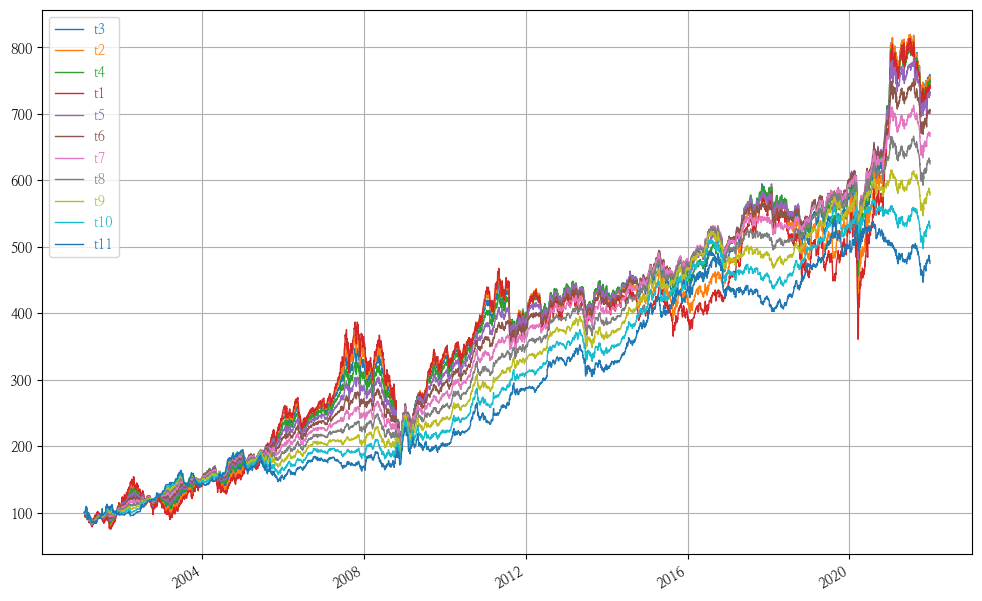

In [12]:
plot_df(r_all.prices, figsize=(12,9), logy=False)

In [13]:
class StatCalcRiskAdjustedReturn(bt.Algo):
    def __init__(self, lookback=6):
        super(StatCalcRiskAdjustedReturn, self).__init__()
        self.lookback = lookback

    def __call__(self, target):
        selected = target.temp['selected']

        prev_month = target.now# - pd.DateOffset(months=1)
        t0 = prev_month.strftime("%Y-%m")
        start = (prev_month - pd.DateOffset(months=self.lookback)).strftime("%Y-%m")

        prc = target.universe.loc[start:t0, selected].resample('M').last()

        월별수익률 = prc.pct_change().dropna()
        변동성 = 월별수익률.std()

        모멘텀 = prc.calc_total_return()
        stats = 모멘텀/변동성
        # print(f"=== {t0} {start} \n{prc}\n==월별수익률\n{월별수익률} \n==returns\n{모멘텀} \n==std\n{변동성}\nstats==\n{stats}\n")

        target.temp['stat'] = pd.Series(stats, index=prc.columns)

        return True

In [14]:
r_all.prices

,t1,t2,t3,t4,t5,t6,t7,t8,t9,t10,t11
2001-01-30,100.000,100.000,100.000,100.000,100.000,100.000,100.000,100.000,100.000,100.000,100.000
2001-01-31,100.000,100.000,100.000,100.000,100.000,100.000,100.000,100.000,100.000,100.000,100.000
2001-02-01,99.094,99.188,99.282,99.375,99.469,99.563,99.657,99.750,99.844,99.938,100.031
2001-02-02,98.368,98.610,98.852,99.095,99.337,99.579,99.821,100.063,100.306,100.548,100.790
2001-02-05,93.470,94.205,94.941,95.677,96.412,97.148,97.884,98.619,99.355,100.090,100.826
...,...,...,...,...,...,...,...,...,...,...,...
2021-12-24,742.930,755.265,757.558,749.753,732.019,705.215,670.274,628.579,581.534,530.809,478.043
2021-12-27,738.578,751.426,754.304,747.131,730.050,703.896,669.576,628.453,581.914,531.615,479.188
2021-12-28,744.597,756.970,759.279,751.468,733.703,706.849,671.837,630.054,582.908,532.072,479.188
2021-12-29,742.930,755.496,758.026,750.452,732.934,706.326,671.549,629.983,583.029,532.355,479.601


In [15]:
s

'2001-1-31'

In [16]:
data1  = r_all.prices[s:]
data1.head()

,t1,t2,t3,t4,t5,t6,t7,t8,t9,t10,t11
2001-01-31,100.000,100.000,100.000,100.000,100.000,100.000,100.000,100.000,100.000,100.000,100.000
2001-02-01,99.094,99.188,99.282,99.375,99.469,99.563,99.657,99.750,99.844,99.938,100.031
2001-02-02,98.368,98.610,98.852,99.095,99.337,99.579,99.821,100.063,100.306,100.548,100.790
2001-02-05,93.470,94.205,94.941,95.677,96.412,97.148,97.884,98.619,99.355,100.090,100.826
2001-02-06,94.680,95.445,96.209,96.975,97.740,98.505,99.270,100.035,100.800,101.565,102.330


In [17]:
after_date = (datetime.strptime(start, '%Y-%m-%d') - pd.DateOffset(days=1)).strftime('%Y-%m-%d')
after_date

'2001-07-30'

In [18]:
st = bt.Strategy("ensemble",
        [
            bt.algos.RunMonthly(run_on_end_of_period=True), #월말
            bt.algos.RunAfterDate(after_date),
            bt.algos.SelectAll(),
            #-------------------------------------------
            StatCalcRiskAdjustedReturn(lookback=6),
            bt.algos.SelectN(3),
            bt.algos.WeighEqually(),
            #-------------------------------------------
            PrintTempWeights(),
            bt.algos.Rebalance()
        ]
)

In [19]:
bt_ensemble = bt.Backtest(st, data1, initial_capital=100000000.0)
r = bt.run(bt_ensemble)

2001-07-31 00:00:00 ensemble t11:0.333 t10:0.333 t9:0.333 
2001-08-31 00:00:00 ensemble t11:0.333 t10:0.333 t9:0.333 
2001-09-28 00:00:00 ensemble t11:0.333 t10:0.333 t9:0.333 
2001-10-31 00:00:00 ensemble t10:0.333 t11:0.333 t9:0.333 
2001-11-30 00:00:00 ensemble t8:0.333 t7:0.333 t9:0.333 
2001-12-28 00:00:00 ensemble t6:0.333 t7:0.333 t5:0.333 
2002-01-31 00:00:00 ensemble t5:0.333 t6:0.333 t4:0.333 
2002-02-28 00:00:00 ensemble t1:0.333 t2:0.333 t3:0.333 
2002-03-29 00:00:00 ensemble t1:0.333 t2:0.333 t3:0.333 
2002-04-30 00:00:00 ensemble t1:0.333 t2:0.333 t3:0.333 
2002-05-31 00:00:00 ensemble t7:0.333 t6:0.333 t8:0.333 
2002-06-28 00:00:00 ensemble t7:0.333 t8:0.333 t9:0.333 
2002-07-31 00:00:00 ensemble t8:0.333 t9:0.333 t10:0.333 
2002-08-30 00:00:00 ensemble t8:0.333 t9:0.333 t10:0.333 
2002-09-30 00:00:00 ensemble t11:0.333 t10:0.333 t9:0.333 
2002-10-31 00:00:00 ensemble t11:0.333 t10:0.333 t9:0.333 
2002-11-29 00:00:00 ensemble t11:0.333 t10:0.333 t9:0.333 
2002-12-30 00:0

In [20]:
r.set_date_range(start,e)
r.display()

Stat                 ensemble
-------------------  ----------
Start                2001-07-31
End                  2021-12-30
Risk-free rate       0.00%

Total Return         1297.77%
Daily Sharpe         1.04
Daily Sortino        1.67
CAGR                 13.79%
Max Drawdown         -30.28%
Calmar Ratio         0.46

MTD                  0.26%
3m                   0.07%
6m                   -7.96%
YTD                  2.37%
1Y                   2.37%
3Y (ann.)            8.81%
5Y (ann.)            11.63%
10Y (ann.)           10.28%
Since Incep. (ann.)  13.79%

Daily Sharpe         1.04
Daily Sortino        1.67
Daily Mean (ann.)    14.08%
Daily Vol (ann.)     13.49%
Daily Skew           -0.19
Daily Kurt           6.21
Best Day             7.66%
Worst Day            -5.98%

Monthly Sharpe       1.01
Monthly Sortino      2.08
Monthly Mean (ann.)  13.91%
Monthly Vol (ann.)   13.78%
Monthly Skew         0.55
Monthly Kurt         3.43
Best Month           21.68%
Worst Month          -11.41

In [21]:
r.prices.resample('M').last().to_drawdown_series().min()

ensemble   -0.279
dtype: float64

<AxesSubplot:>

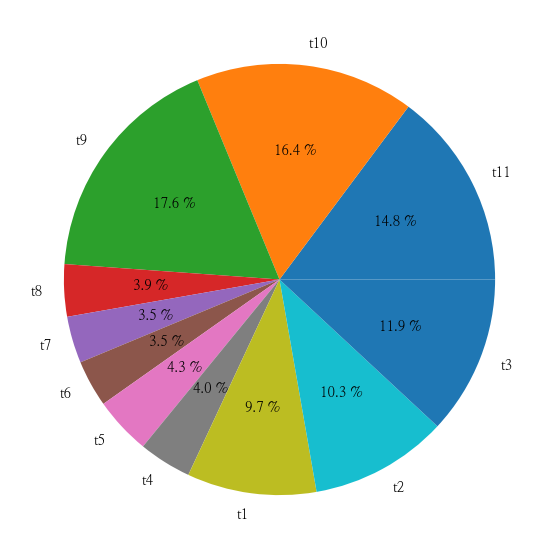

In [22]:
r.get_security_weights().sum(axis=0).plot.pie(autopct='%.1f %%', ylabel='', figsize=(7,7))

In [23]:
bt_kospi = long_only_ew(data, ['kodex200'], 'kodex200')
bt_bond = long_only_ew(data, ['kbond20y'], 'kbond20y')

r_kospi = bt.run(bt_kospi)
r_bond  = bt.run(bt_bond)

2001-01-31 00:00:00
2001-01-31 00:00:00


In [24]:
st_ew = bt.Strategy("ew",
        [
            bt.algos.RunMonthly(run_on_end_of_period=True),
            bt.algos.RunAfterDate(after_date),
            bt.algos.SelectAll(),
            #-------------------------------------------
            bt.algos.WeighEqually(),
            #-------------------------------------------
            PrintTempWeights(),
            bt.algos.Rebalance()
        ]
)
bt_ew = bt.Backtest(st_ew, data, initial_capital=100000000.0)
r_ew = bt.run(bt_ew)

2001-07-31 00:00:00 ew kodex200:0.500 kbond20y:0.500 
2001-08-31 00:00:00 ew kodex200:0.500 kbond20y:0.500 
2001-09-28 00:00:00 ew kodex200:0.500 kbond20y:0.500 
2001-10-31 00:00:00 ew kodex200:0.500 kbond20y:0.500 
2001-11-30 00:00:00 ew kodex200:0.500 kbond20y:0.500 
2001-12-28 00:00:00 ew kodex200:0.500 kbond20y:0.500 
2002-01-31 00:00:00 ew kodex200:0.500 kbond20y:0.500 
2002-02-28 00:00:00 ew kodex200:0.500 kbond20y:0.500 
2002-03-29 00:00:00 ew kodex200:0.500 kbond20y:0.500 
2002-04-30 00:00:00 ew kodex200:0.500 kbond20y:0.500 
2002-05-31 00:00:00 ew kodex200:0.500 kbond20y:0.500 
2002-06-28 00:00:00 ew kodex200:0.500 kbond20y:0.500 
2002-07-31 00:00:00 ew kodex200:0.500 kbond20y:0.500 
2002-08-30 00:00:00 ew kodex200:0.500 kbond20y:0.500 
2002-09-30 00:00:00 ew kodex200:0.500 kbond20y:0.500 
2002-10-31 00:00:00 ew kodex200:0.500 kbond20y:0.500 
2002-11-29 00:00:00 ew kodex200:0.500 kbond20y:0.500 
2002-12-30 00:00:00 ew kodex200:0.500 kbond20y:0.500 
2003-01-30 00:00:00 ew kodex

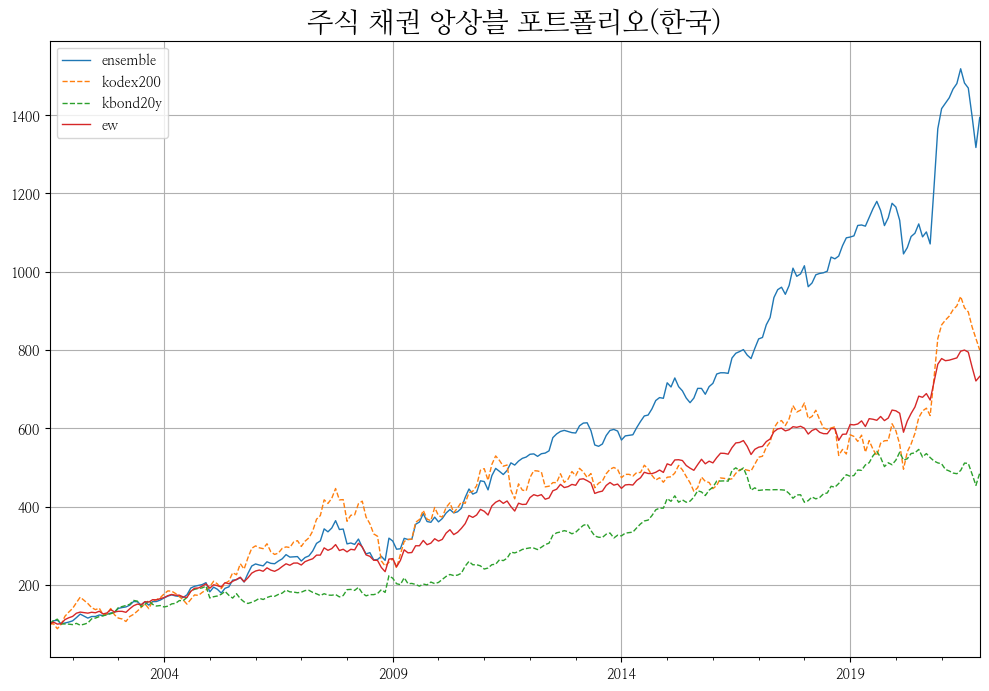

In [25]:
r_kospi.set_date_range(start,e)
r_bond.set_date_range(start,e)
r_ew.set_date_range(start,e)

ax1 = r.plot(freq='M', figsize=(12,8));
r_kospi.plot(ax=ax1, freq='M', ls='--', figsize=(12,8));
r_bond.plot(ax=ax1, freq='M', ls='--', figsize=(12,8));
r_ew.plot(ax=ax1, freq='M', ls='-', figsize=(12,8));
plt.title("주식 채권 앙상블 포트폴리오(한국)", fontsize=20);

In [26]:
r_asset = bt.run(bt_kospi, bt_bond, bt_ew, bt_ensemble)
r_asset.set_date_range(start, e)
r_asset.display()

Stat                 kodex200    kbond20y    ew          ensemble
-------------------  ----------  ----------  ----------  ----------
Start                2001-07-31  2001-07-31  2001-07-31  2001-07-31
End                  2021-12-30  2021-12-30  2021-12-30  2021-12-30
Risk-free rate       0.00%       0.00%       0.00%       0.00%

Total Return         752.27%     383.50%     655.18%     1297.77%
Daily Sharpe         0.59        0.70        0.90        1.04
Daily Sortino        0.94        1.12        1.47        1.67
CAGR                 11.07%      8.02%       10.41%      13.79%
Max Drawdown         -52.67%     -24.47%     -29.18%     -30.28%
Calmar Ratio         0.21        0.33        0.36        0.46

MTD                  6.52%       -0.44%      3.04%       0.26%
3m                   -0.81%      0.09%       -0.16%      0.07%
6m                   -9.05%      -1.83%      -5.27%      -7.96%
YTD                  2.77%       -5.54%      -1.15%      2.37%
1Y                   2.77%     

In [27]:
r_asset.prices.resample('M').last().to_drawdown_series().min()

kodex200   -0.455
kbond20y   -0.225
ew         -0.237
ensemble   -0.279
dtype: float64

In [28]:
r_asset.prices.resample('MS').first().to_drawdown_series().min()

kodex200   -0.468
kbond20y   -0.216
ew         -0.245
ensemble   -0.290
dtype: float64

           CAGR
kodex200 11.066
kbond20y  8.025
ew       10.410
ensemble 13.790
             MDD
kodex200 -52.667
kbond20y -24.470
ew       -29.180
ensemble -30.281


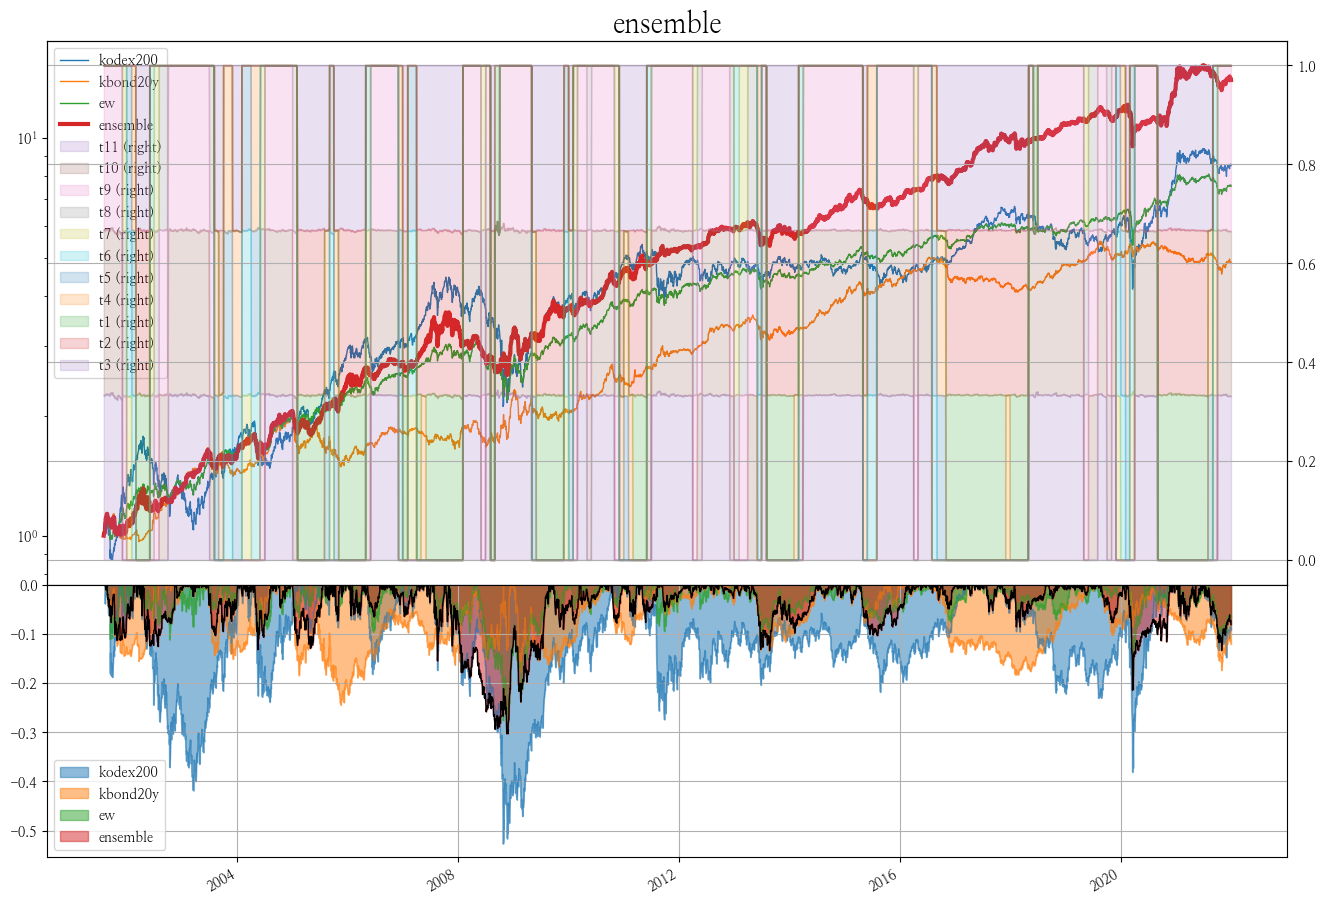

In [29]:
plot_assets(r_asset, start, e, 'ensemble')